<a href="https://colab.research.google.com/github/janakan97/Evol-AutoNN/blob/main/Evol_AutoNN1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evol-AutoNN 1.0
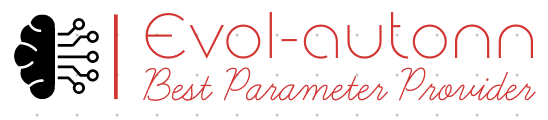

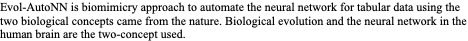

Evol-AutoNN is an application developed with darwins concept of evolution which is an biology the change in the gene of species in several generation to automatate the process of neural network for tabular data. 

The Intial Set of work and the documentation of the project

function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

# Works in all flows of the project

# Intial Project documentation  

Dateset Path

**`phoneme data`**

/content/drive/MyDrive/Dataset/phoneme/train.csv

**`amazon-employee data`**

/content/drive/MyDrive/Dataset/amazon-employee/train.csv

**`aps failure`**

/content/drive/MyDrive/Dataset/aps_failure/train.csv

# Validation Container

Setup

In [ ]:
# Getting useful tabular processing and generator functions
!git clone https://github.com/lmassaron/deep_learning_for_tabular_data.git

# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib
import csv
from collections import Counter

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
!pip install wandb



Data Collection
Once the mounting with the drive is done user will be prompted with the link to select the google drive which has the dataset and provied the location

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
location = input("Enter the drive location : ")

Enter the drive location : /content/drive/MyDrive/Dataset/adult/adult.csv


In [ ]:
#X - train data 
X= pd.read_csv(location)
X.head()

In [ ]:
target = input("Enter the target variable : ")

Enter the target variable : income


# Preprocessing

In [ ]:

def frequency_encoding(column, df, df_test=None):
    frequencies = df[column].value_counts().reset_index()
    df_values = df[[column]].merge(frequencies, how='left', 
                                   left_on=column, right_on='index').iloc[:,-1].values
    if df_test is not None:
        df_test_values = df_test[[column]].merge(frequencies, how='left', 
                                                 left_on=column, right_on='index').fillna(1).iloc[:,-1].values
    else:
        df_test_values = None
    return df_values, df_test_values

In [ ]:
# Transforming all the labels of all variables
from sklearn.preprocessing import LabelEncoder


def preprocess(target,X):
  y = X[target]
  # summarize observations by class label
  counter = Counter(y) 
  key, value = counter.items() 
  # y - It is the taget contating the column provided by the user
  y = X[target].apply(lambda x: 1 if x == key[0] else 0).values
  X.drop([target], axis=1, inplace=True)

  label_encoders = [LabelEncoder() for _ in range(X.shape[1])]

  for col, column in enumerate(X.columns):
    label_encoders[col].fit(X[column])
    X[column] = label_encoders[col].transform(X[column])

  for column in X.columns:
    train_values, test_values = frequency_encoding(column, X)
    X[column + '_counts'] = train_values

  # Pointing out which variables are categorical and which are numeric
  categorical_variables = [col for col in X.columns if '_counts' not in col]
  numeric_variables = [col for col in X.columns if '_counts' in col]

  return categorical_variables, numeric_variables, X, y


# **Neural Network**

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.layers import Input, Embedding, Reshape, GlobalAveragePooling1D
from tensorflow.keras.layers import Flatten, concatenate, Concatenate, Lambda, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Reshape, MaxPooling1D,BatchNormalization, AveragePooling1D, Conv1D
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1_l2
from keras.losses import binary_crossentropy

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score,accuracy_score
from sklearn.metrics import accuracy_score,average_precision_score

import matplotlib.pyplot as plt

## Activation Functions

In [ ]:
# Registering custom activations suitable for tabular problems

from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from deep_learning_for_tabular_data.tabular import gelu, Mish, mish

### gelu

In [ ]:
# Add gelu so we can use it as a string
get_custom_objects().update({'gelu': Activation(gelu)})

###Mish

In [ ]:
# Add mish so we can use it as a string
get_custom_objects().update({'mish': Mish(mish)})

###LeakyRelu

In [ ]:
# Add leaky-relu so we can use it as a string
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.2))})

###Architecture

In [ ]:
# Parametric architecture
def tabular_dnn(numeric_variables, categorical_variables, categorical_counts,first_dense,second_dense,activation_type,
                feature_selection_dropout=0.2, categorical_dropout=0.1, dense_dropout = 0.2):
    
    print("The number neurons in the first layer")
    print(first_dense)
    print("The number neurons in the second layer")
    print(second_dense)
    print("The activation type ")
    print(activation_type)

    numerical_inputs = Input(shape=(len(numeric_variables),))
    numerical_normalization = BatchNormalization()(numerical_inputs)
    numerical_feature_selection = Dropout(feature_selection_dropout)(numerical_normalization)

    categorical_inputs = []
    categorical_embeddings = []
    for category in  categorical_variables:
        categorical_inputs.append(Input(shape=[1], name=category))
        category_counts = categorical_counts[category]
        categorical_embeddings.append(
            Embedding(category_counts+1, 
                      int(np.log1p(category_counts)+1), 
                      name = category + "_embed")(categorical_inputs[-1]))

    categorical_logits = Concatenate(name = "categorical_conc")([Flatten()(SpatialDropout1D(categorical_dropout)(cat_emb)) 
                                                                 for cat_emb in categorical_embeddings])

    x = concatenate([numerical_feature_selection, categorical_logits])
    x = Dense(first_dense, activation=activation_type)(x)
    x = Dropout(dense_dropout)(x)  
    x = Dense(second_dense, activation=activation_type)(x)
    x = Dropout(dense_dropout)(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model([numerical_inputs] + categorical_inputs, output)
    
    return model

In [ ]:
# Useful functions

from tensorflow.keras.metrics import AUC

def mAP(y_true, y_pred):
    return tf.py_function(average_precision_score, (y_true, y_pred), tf.double)

def compile_model(model, loss, metrics, optimizer):
    model.compile(loss=loss, metrics=metrics, optimizer=optimizer)
    return model

def plot_keras_history(history, measures):
    """
    history: Keras training history
    measures = list of names of measures
    """
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label="Train "+measure)
        panel.plot(history.epoch, history.history["val_"+measure], label="Validation "+measure)
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)

In [ ]:
# Global training settings
SEED = 42
FOLDS = 3
BATCH_SIZE = 512

In [ ]:
# Defining callbacks

measure_to_monitor = 'val_auc' 
modality = 'max'

early_stopping = EarlyStopping(monitor=measure_to_monitor, 
                               mode=modality, 
                               patience=3, 
                               verbose=0)

model_checkpoint = ModelCheckpoint('best.model', 
                                   monitor=measure_to_monitor, 
                                   mode=modality, 
                                   save_best_only=True, 
                                   verbose=0)

In [ ]:
from deep_learning_for_tabular_data.tabular import TabularTransformer, DataGenerator
import time
# Setting the CV strategy

def algorithm_learner(first_neuron,second_neuron,activation_type,numeric_variables,categorical_variables,X,y):
  
    skf = StratifiedKFold(n_splits=FOLDS, 
                      shuffle=True, 
                      random_state=SEED)

    # CV Iteration
    roc_auc = list()
    average_precision = list()
    oof = np.zeros(len(X))
    best_iteration = list()
    start_time = time. time()

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
     
        tb = TabularTransformer(numeric = numeric_variables,ordinal = [],lowcat  = [],
                            highcat = categorical_variables)

        tb.fit(X.iloc[train_idx])
        sizes = tb.shape(X.iloc[train_idx])
        categorical_levels = dict(zip(categorical_variables, sizes[1:]))
        print(f"Input array sizes: {sizes}")
        print(f"Categorical levels: {categorical_levels}\n")
     
        model = tabular_dnn(numeric_variables, categorical_variables,categorical_levels, first_neuron,second_neuron,activation_type,
                        feature_selection_dropout=0.1,categorical_dropout=0.1, dense_dropout = 0.1 )
   
        model = compile_model(model, binary_crossentropy, [AUC(name='auc'), mAP], Adam(learning_rate=0.0001))
    
        train_batch = DataGenerator(X.iloc[train_idx], 
                                y[train_idx],
                                tabular_transformer=tb,
                                batch_size=BATCH_SIZE,
                                shuffle=True)
    
     
        history = model.fit(train_batch,
                        validation_data=(tb.transform(X.iloc[test_idx]), y[test_idx]),
                        epochs=10,
                        callbacks=[model_checkpoint, early_stopping],
                        class_weight={0:1.0, 1:(np.sum(y==0) / np.sum(y==1))},
                        verbose=1)
    
        print("\nFOLD %i" % fold)
        plot_keras_history(history, measures=['auc', 'loss'])
    
        best_iteration.append(np.argmax(history.history['val_auc']) + 1)
        preds = model.predict(tb.transform(X.iloc[test_idx]),
                          verbose=1,
                          batch_size=1024).flatten()

        oof[test_idx] = preds

        roc_auc.append(roc_auc_score(y_true=y[test_idx], y_score=preds))
        average_precision.append(average_precision_score(y_true=y[test_idx], y_score=preds))

        

        print("Average cv roc auc score %0.3f ± %0.3f" % (np.mean(roc_auc), np.std(roc_auc)))
        print("Average cv roc average precision %0.3f ± %0.3f" % (np.mean(average_precision), np.std(average_precision)))

        score_roc_auc=roc_auc_score(y_true=y, y_score=oof)
        print("Roc auc score OOF %0.3f" % score_roc_auc )
        avg_pre_acr=average_precision_score(y_true=y, y_score=oof)
        print("Average precision OOF %0.3f" % avg_pre_acr )

        return (avg_pre_acr+score_roc_auc)/2
    


# **Evolutionary Algorithm**


##Decoder

In [ ]:

from numpy.random import randint
from numpy.random import rand


def decoder(x):
    #Total length of chromosome is divided into 2 
    f_layer = x[:6]
    s_layer = x[6:13]
    a_function = x[13:15]
    a_function=int(''.join(map(lambda a_function: str(int(a_function)), a_function)), 2)
    if a_function == 1:
      a_function = 'gelu'
      if a_function == 2:
        a_function = 'mish'
    else:
      a_function ='leaky-relu'
    #Divide chromosomes create the number for neurons in the layer
    f_neurons=1+int(''.join(map(lambda f_layer: str(int(f_layer)), f_layer)), 2)
    s_neurons=1+int(''.join(map(lambda s_layer: str(int(s_layer)), s_layer)), 2)
    print("First layer nerons", f_neurons)
    print("Second layer nerons",s_neurons)
    print("The activation function", a_function)
    return f_neurons, s_neurons, a_function ; 

##Objective Function

In [ ]:

# objective function for the neural network
def objective(x,categorical_variables,numeric_variables,X,y):
    f_neurons,s_neurons, activation = decoder(x)
    avg_score=algorithm_learner(f_neurons,s_neurons,activation,numeric_variables,categorical_variables,X,y)
    print("returnig the avg_score")
    return avg_score

##Operation of GA

###Selection

In [ ]:
# tournament selection
def selection(pop, scores, k=3):
	  # first random selection
	  selection_ix = randint(len(pop))
	  for ix in randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		  if scores[ix] > scores[selection_ix]:
			  selection_ix = ix
	  return pop[selection_ix]


###Crossover

In [ ]:

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if rand() > r_cross:
		# select crossover point that is not on the end of the string
		pt = randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]


###Mutation

In [ ]:
# mutation operator
def mutation(bitstring, r_mut):
	for i in range(len(bitstring)):
		# check for a mutation
		if rand() > r_mut:
			# flip the bit
			bitstring[i] = 1 - bitstring[i]

##Genetic Algorithm

In [ ]:
# genetic algorithm
def genetic_algorithm(B_sec, objective,categorical_variables,numeric_variables,X,y, n_gen, n_pop, r_cross, r_mut):
  n_bits = 15
  # initial population of random bitstring
  pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
  # printing the initilized population
  print("The population")
  for x in range(len(pop)):
    print(pop[x])

  starting_time = time.time()
  # keep track of best solution
  best, best_eval = 0, objective(pop[0],categorical_variables,numeric_variables,X,y)
  trained_time=0
  
  while (B_sec >= trained_time):
    # evaluate all candidates in the population
    scores = [objective(c,categorical_variables,numeric_variables,X,y) for c in pop]

    print("Budget in sec", B_sec)
    print("Train time", trained_time)

  # check for new best solution
    for i in range(n_pop):
      if scores[i] > best_eval:
        best, best_eval = pop[i], scores[i]
        print(">%d, new best f(%s) = %.3f" % (n_gen, pop[i], scores[i]))
  # select parents

    selected = [selection(pop, scores) for _ in range(n_pop)]

  # create the next generation
    children = list()

    for i in range(0, n_pop, 2):
    # get selected parents in pairs
      p1, p2 = selected[i], selected[i + 1]
    # crossover and mutation
      for c in crossover(p1, p2, r_cross):
      # mutation
        mutation(c, r_mut)
      # store for next generation
        children.append(c)
  # replace population
    pop = children
    trained_time = time.time() - starting_time

  return [best, best_eval]





In [ ]:
# genetic algorithm
def genetic_algorithmforparam(objective,categorical_variables,numeric_variables,X,y, n_gen, n_pop, r_cross, r_mut):
  n_bits = 15
  print ("number of  gen", n_gen)
  print ("number of  pop", n_pop)
  print ("number of  cross", r_cross)
  print ("number of  mut", r_mut)
  # initial population of random bitstring
  pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
  # printing the initilized population
  print("The population")
  for x in range(len(pop)):
    print(pop[x])

  starting_time = time.time()
  # keep track of best solution
  best, best_eval = 0, objective(pop[0],categorical_variables,numeric_variables,X,y)

  
  
  # evaluate all candidates in the population
  scores = [objective(c,categorical_variables,numeric_variables,X,y) for c in pop]



  # check for new best solution
  for i in range(n_pop):
   if scores[i] > best_eval:
     best, best_eval = pop[i], scores[i]
     print(">%d, new best f(%s) = %.3f" % (n_gen, pop[i], scores[i]))
  # select parents

  selected = [selection(pop, scores) for _ in range(n_pop)]

  # create the next generation
  children = list()

  for i in range(0, n_pop, 2):
    # get selected parents in pairs
    p1, p2 = selected[i], selected[i + 1]
    # crossover and mutation
    for c in crossover(p1, p2, r_cross):
      # mutation
      mutation(c, r_mut)
      # store for next generation
      children.append(c)
  # replace population
  pop = children
    

  return [best, best_eval]





In [ ]:
def EvolAutoNN(target,X):
    print(target)
    target=str(target)
    categorical_variables, numeric_variables, X, y =preprocess(target,X)
    X, X_test, y, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)
    print(categorical_variables)
    option = input("Selection the option to run : \n 1. Run with Budget \n 2. Change the configuration \n ")
    if(option == "1"):
      print("Budget Available :- 1hour , 2hour , 3hour")
      budget = input("Enter the Budget : ")
      #convert the budget to secod
      B_sec = int(budget)*60*60
      print("learning Begins ")
      best, score = genetic_algorithm(B_sec,objective,categorical_variables,numeric_variables,X,y,n_gen=2,n_pop=10,r_cross= 0.7,r_mut=1.0 / float(15))
    else:
      print("The degfault values used are listed below if you want change type Yes and if you dont want to  change any parameter type No")
      print("No. of generation",2)
      print("No. of poplation",10)
      print("Crossover rate",0.7)
      print("Mutation rate",0.0625)
      n_gen= int(input("Input the number of generation "))
      n_pop= int(input("Input the nmber of population"))
      r_cross= float( input("Input the crossover rate"))
      r_mut= float( input("Input the mutation rate"))
      best, score = genetic_algorithmforparam(objective,categorical_variables,numeric_variables,X,y,n_gen,n_pop,r_cross,r_mut)
    print('Done!')
    print('f(%s) = %f' % (best, score)) 
    return best,categorical_variables,numeric_variables,X_test,y_test,X,y

In [ ]:
best,categorical_variables,numeric_variables,X_test,y_test,X,y = EvolAutoNN(target,X)

In [ ]:
f_neurons,s_neurons,a_function = decoder(best)

#Testing

In [ ]:
def TestEvolAutoNN(best,categorical_variables,numeric_variables,X_test,y_test,X,y):
  f_neurons,s_neurons,a_function = decoder(best)
  ## We train on all the examples, using a rule of thumb for the number of iterations

  tb = TabularTransformer(numeric = numeric_variables,
                        ordinal = [],
                        lowcat  = [],
                        highcat = categorical_variables)

  tb.fit(X)
  sizes = tb.shape(X)
  categorical_levels = dict(zip(categorical_variables, sizes[1:]))
  print(f"Input array sizes: {sizes}")
  print(f"Categorical levels: {categorical_levels}\n")

  model = tabular_dnn(numeric_variables, categorical_variables,categorical_levels, f_neurons,s_neurons,a_function,
                        feature_selection_dropout=0.1,categorical_dropout=0.1, dense_dropout = 0.1 
                        )
    
  model = compile_model(model, binary_crossentropy, [AUC(name='auc'), mAP], Adam(learning_rate=0.0001))    

  train_batch = DataGenerator(X, y,
                            tabular_transformer=tb,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

  history = model.fit(train_batch,
                    epochs= 11,
                    class_weight={0:1.0, 1:(np.sum(y==0) / np.sum(y==1))},
                    verbose=1)

  #plot_keras_history(history, measures=['auc', 'loss'])

  # Predicting 
  preds = model.predict(tb.transform(X_test[X.columns]),
                      verbose=1,
                      batch_size=1024).flatten()
  preds=np.around(preds).astype(int)
  print("AUC- ROC Score",roc_auc_score(y_true=y_test, y_score=preds))
  print("Average Precision Score",average_precision_score(y_true=y_test, y_score=preds))
  y_true = y_test
  y_pred = preds
  print("accuracy")
  print(accuracy_score(y_true, y_pred))
  print("precision")
  print(average_precision_score(y_true, y_pred))


In [ ]:
test_confirm = input("Do you want test the parameters : ")
if(test_confirm == 'Yes'):
  TestEvolAutoNN(best,categorical_variables,numeric_variables,X_test,y_test,X,y)

  

# Performance

In [ ]:
!nvidia-smi

In [ ]:
import wandb
wandb.init()